In [1]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# connect to the database
conn = sqlite3.connect('../max-experiments/itinerary-scraping/journeys.db')
cursor = conn.cursor()

# get all outages
cursor.execute('SELECT * FROM outages')
outages = cursor.fetchall()
# outages

In [3]:
cursor.execute('SELECT * FROM outages')
outages = cursor.fetchall()

cursor.execute('SELECT * FROM journeys')
journeys = cursor.fetchall()

# number of outages
print(len(outages))

print('---')
print("% of journeys with outages:", round(len(outages)/len(journeys) * 100, 3))

213
---
% of journeys with outages: 0.042


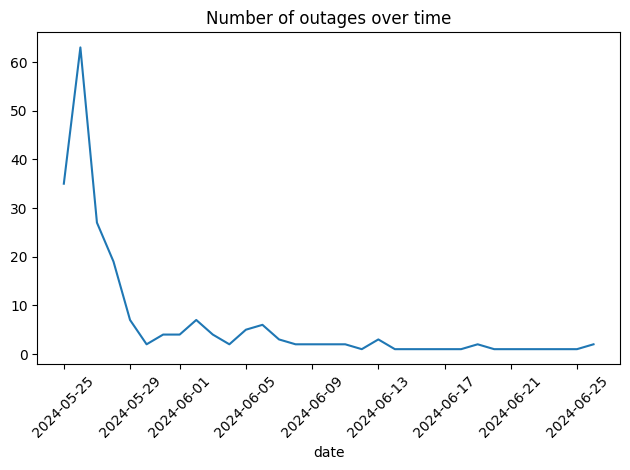

In [4]:
outages_df = pd.DataFrame(outages, columns=['outage_id', 'stop_id', 'effect', 'updated_at', 'outage_data'])

outages_df['updated_at'] = pd.to_datetime(outages_df['updated_at'])
outages_df['date'] = outages_df['updated_at'].dt.date

# plot number of outages over time
outages_df.groupby('date').size().plot()
plt.title('Number of outages over time')
# rotate x-axis labels
plt.xticks(rotation=45)
# evenly space x-axis labels
plt.tight_layout()
plt.savefig('out/outages/outages_over_time.png', bbox_inches='tight')
plt.show()

In [5]:
outages_df

,outage_id,stop_id,effect,updated_at,outage_data,date
0,828,stop_point:tcl:SP:30205,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Acc\u00e8s ferm\u00e9 pou...",2024-05-25
1,503,stop_point:tcl:SP:46036,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-25
2,242,stop_point:tcl:SP:30156,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-25
3,2604,stop_point:tcl:SP:46051,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-25
4,2302,stop_point:tcl:SP:46053,unavailable,2024-05-25 17:28:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-05-25
...,...,...,...,...,...,...
208,2103,stop_point:tcl:SP:46055,unavailable,2024-06-22 04:48:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-22
209,5101,stop_point:tcl:SP:48137,unavailable,2024-06-24 04:53:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-24
210,731,stop_point:tcl:SP:30187,unavailable,2024-06-25 09:38:00+02:00,"{""cause"": {""label"": ""Entretien programm\u00e9""...",2024-06-25
211,5104,stop_point:tcl:SP:48136,unavailable,2024-06-26 04:53:00+02:00,"{""cause"": {""label"": ""Panne""}, ""effect"": {""labe...",2024-06-26


In [6]:
# average length of outages
durations = []
for row in outages_df['outage_data']:
    row = row.split('begin')[1]
    
    # format is now ": "20240525T000000", "end": "20240525T193000"}]}
    # we want to extract the two dates and calculate the difference
    row = row[4:]   # cut off the first ": "
    
    # begin is the next 15 characters
    begin = row[:15]
    row = row[26:]      # cut to the end date
    
    # end is the next 15 characters
    end = row[:15]
    
    # calculate the difference
    begin = pd.to_datetime(begin)
    end = pd.to_datetime(end)
    # print(begin, end)
    
    # convert to seconds
    duration = (end - begin).total_seconds()
    durations.append(duration)
    
print('Average outage duration:', round(sum(durations)/len(durations), 3), 'seconds')
print('Median outage duration:', pd.Series(durations).median(), 'seconds')
print('----------')

q1 = pd.Series(durations).quantile(0.25)
q3 = pd.Series(durations).quantile(0.75)
iqr = q3 - q1

# remove outliers
durations_no_outliers = [duration for duration in durations if duration < q3 + 1.5*iqr]
print('Average outage duration (no outliers):', round(sum(durations_no_outliers)/len(durations_no_outliers), 3), 'seconds')
print('Median outage duration (no outliers):', pd.Series(durations_no_outliers).median(), 'seconds')

outages_df['duration'] = durations # add duration to the dataframe

Average outage duration: 409994.366 seconds
Median outage duration: 37800.0 seconds
----------
Average outage duration (no outliers): 43273.096 seconds
Median outage duration (no outliers): 30600.0 seconds


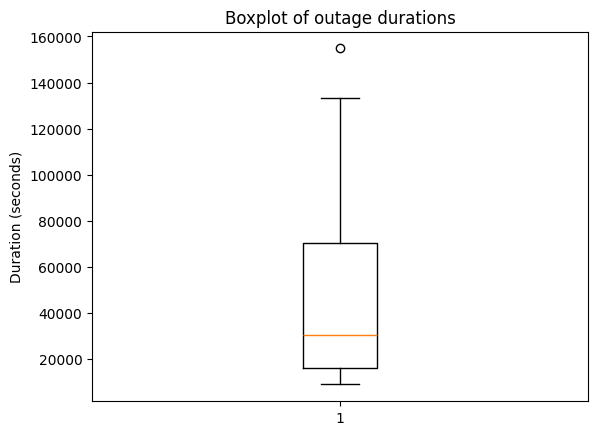

In [7]:
# boxplot of outage durations
plt.boxplot(durations_no_outliers)
plt.title('Boxplot of outage durations')
plt.ylabel('Duration (seconds)')
plt.savefig('out/outages/outage_durations.png')
plt.show()

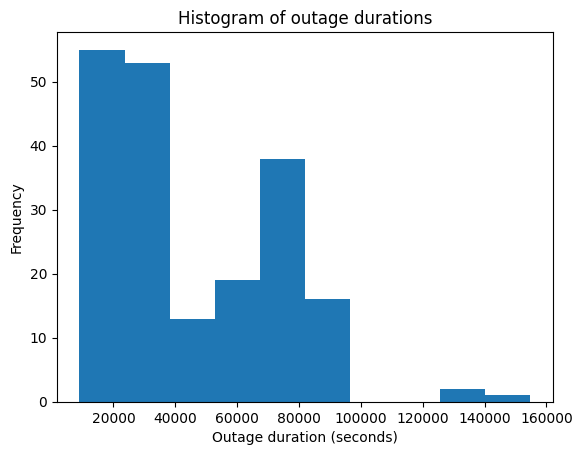

In [8]:
# histogram of outage durations
pd.Series(durations_no_outliers).hist(bins=10)
plt.title('Histogram of outage durations')
plt.xlabel('Outage duration (seconds)')
plt.ylabel('Frequency')
plt.grid(False)
plt.savefig('out/outages/outage_durations_hist.png')
plt.show()

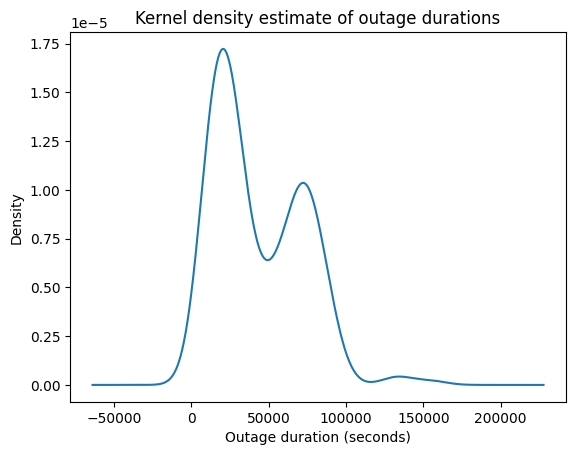

In [9]:
# Kernel density estimate of outage durations
pd.Series(durations_no_outliers).plot.kde()
plt.title('Kernel density estimate of outage durations')
plt.xlabel('Outage duration (seconds)')
plt.ylabel('Density')
plt.grid(False)
plt.savefig('out/outages/outage_durations_kde.png')
plt.show()

In [10]:
# frequency of outages
from collections import Counter
outage_freq = Counter([outage[1] for outage in outages])
print(outage_freq)

# get the stop names
cursor.execute('SELECT * FROM stops')
stops = cursor.fetchall()

stop_names = {}
for stop in stops:
    stop_names[stop[0]] = stop[1]
    
# get the most frequent outages
most_frequent_outages = sorted(outage_freq.items(), key=lambda x: x[1], reverse=True)
# print(most_frequent_outages)
# for stop_id, freq in most_frequent_outages:
#     print(stop_names[stop_id], freq)


Counter({'stop_point:tcl:SP:30209': 9, 'stop_point:tcl:SP:46024': 8, 'stop_point:tcl:SP:46051': 7, 'stop_point:tcl:SP:30205': 5, 'stop_point:tcl:SP:48137': 5, 'stop_point:tcl:SP:30189': 5, 'stop_point:tcl:SP:30197': 5, 'stop_point:tcl:SP:46033': 5, 'stop_point:tcl:SP:46036': 4, 'stop_point:tcl:SP:30200': 4, 'stop_point:tcl:SP:46058': 4, 'stop_point:tcl:SP:30445': 4, 'stop_point:tcl:SP:30211': 4, 'stop_point:tcl:SP:30156': 3, 'stop_point:tcl:SP:46053': 3, 'stop_point:tcl:SP:46054': 3, 'stop_point:tcl:SP:33265': 3, 'stop_point:tcl:SP:46026': 3, 'stop_point:tcl:SP:31663': 3, 'stop_point:tcl:SP:46028': 3, 'stop_point:tcl:SP:30448': 3, 'stop_point:tcl:SP:30184': 3, 'stop_point:tcl:SP:30198': 3, 'stop_point:tcl:SP:30208': 3, 'stop_point:tcl:SP:46060': 3, 'stop_point:tcl:SP:46025': 3, 'stop_point:tcl:SP:48138': 3, 'stop_point:tcl:SP:42744': 3, 'stop_point:tcl:SP:42738': 3, 'stop_point:tcl:SP:30185': 3, 'stop_point:tcl:SP:36394': 3, 'stop_point:tcl:SP:30191': 3, 'stop_point:tcl:SP:30199': 3, '

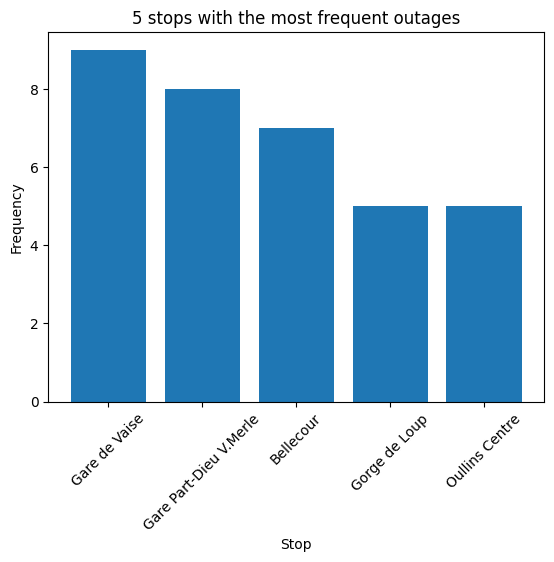

In [11]:
# Plot the 5 stops with the most frequent outages
top_5 = most_frequent_outages[:5]
top_5_names = [stop_names[stop_id] for stop_id, freq in top_5]
top_5_freq = [freq for stop_id, freq in top_5]

plt.bar(top_5_names, top_5_freq)
plt.title('5 stops with the most frequent outages')
plt.xlabel('Stop')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.savefig('out/outages/top_5_outages.png', bbox_inches='tight')
plt.show()

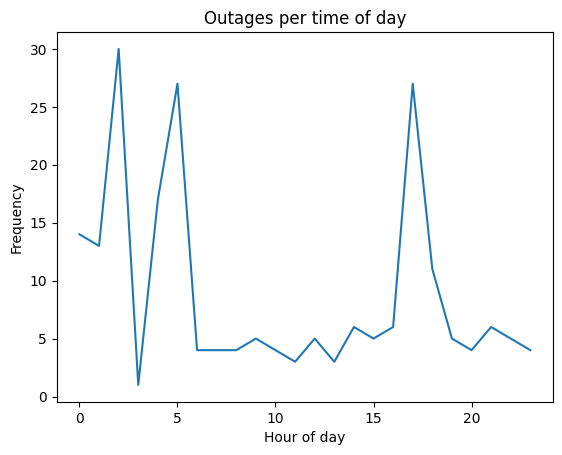

In [12]:
# plot outages per time of day
outages_df['hour'] = outages_df['updated_at'].dt.hour
outages_df.groupby('hour').size().plot()
plt.title('Outages per time of day')
plt.xlabel('Hour of day')
plt.ylabel('Frequency')
plt.savefig('out/outages/outages_per_time_of_day.png')
plt.show()

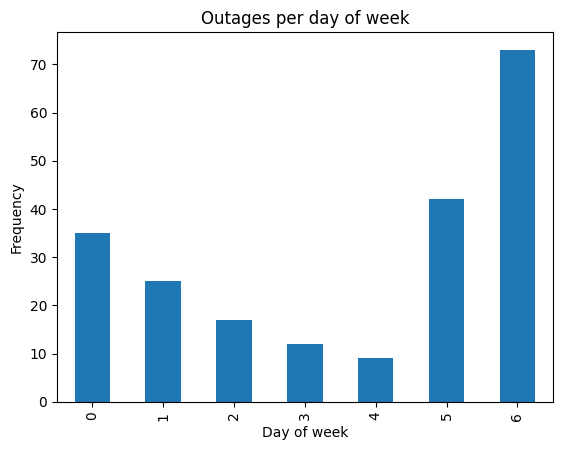

In [13]:
# barplot outages per day of week
outages_df['day_of_week'] = outages_df['updated_at'].dt.dayofweek
outages_df.groupby('day_of_week').size().plot(kind='bar')
plt.title('Outages per day of week')
plt.xlabel('Day of week')
plt.ylabel('Frequency')
plt.savefig('out/outages/outages_per_day_of_week.png')
plt.show()

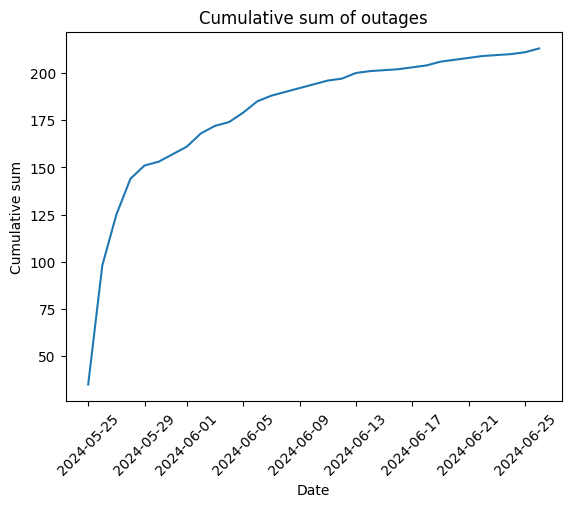

In [14]:
# cumulative sum plot of outages
outages_df.groupby('date').size().cumsum().plot()
plt.title('Cumulative sum of outages')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Cumulative sum')
plt.savefig('out/outages/cumulative_sum_outages.png', bbox_inches='tight')
plt.show()

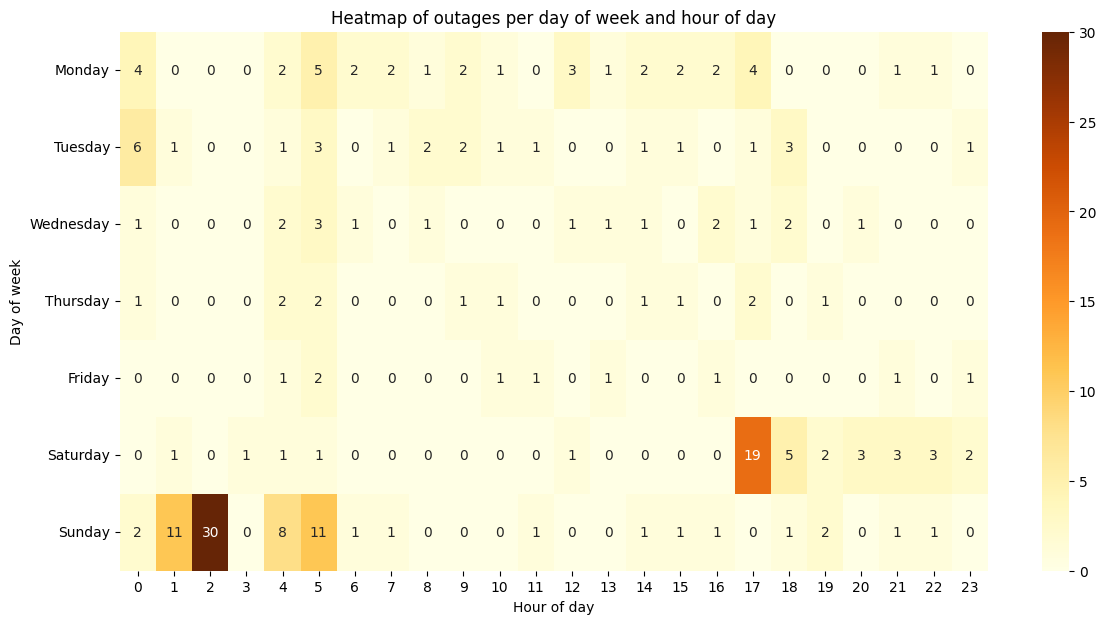

In [15]:
import seaborn as sns
# 2D heatmap of outages per day of week and hour of day
heatmap_data = outages_df.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)

# reorder the days of the week
heatmap_data = heatmap_data.reindex(index=[0, 1, 2, 3, 4, 5, 6])

# plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data, cmap='YlOrBr', annot=True, fmt='d')
plt.title('Heatmap of outages per day of week and hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Day of week')

# add the day of week labels
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.yticks(rotation=0)

plt.savefig('out/outages/heatmap_outages.png')
plt.show()

In [16]:
import json
outages_df['outage_data'] = outages_df['outage_data'].apply(lambda x: json.loads(x))
outages_df['label'] = outages_df['outage_data'].apply(lambda x: x['cause']['label'])
outages_df.head()


,outage_id,stop_id,effect,updated_at,outage_data,date,duration,hour,day_of_week,label
0,828,stop_point:tcl:SP:30205,unavailable,2024-05-25 17:28:00+02:00,{'cause': {'label': 'Accès fermé pour travaux'...,2024-05-25,70200.0,17,5,Accès fermé pour travaux
1,503,stop_point:tcl:SP:46036,unavailable,2024-05-25 17:28:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,588600.0,17,5,Panne
2,242,stop_point:tcl:SP:30156,unavailable,2024-05-25 17:28:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,70200.0,17,5,Panne
3,2604,stop_point:tcl:SP:46051,unavailable,2024-05-25 17:28:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,70200.0,17,5,Panne
4,2302,stop_point:tcl:SP:46053,unavailable,2024-05-25 17:28:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,8811000.0,17,5,Panne


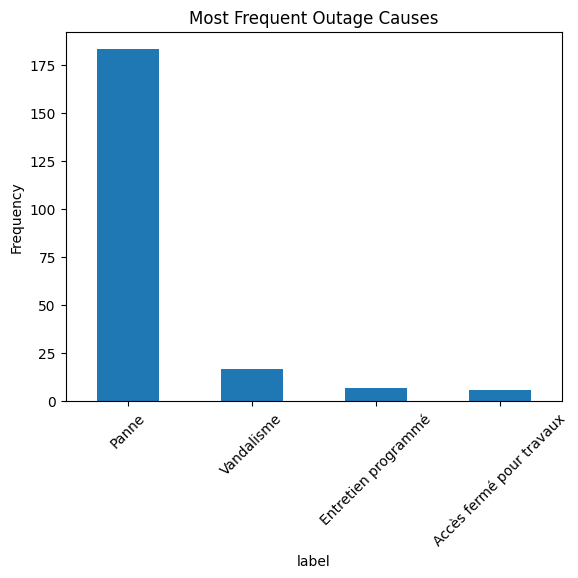

In [17]:
# barchart of most frequent labels
outages_df.groupby('label').size().sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Frequent Outage Causes')
plt.savefig('out/outages/most_frequent_causes.png', bbox_inches='tight')
plt.show()

In [18]:
# average length of outages using 'updated_at' column as start date
durations = []
for index, row in outages_df.iterrows():
    begin = row['updated_at']
    
    # format is now ": "20240525T000000", "end": "20240525T193000"}]}
    # we want to extract the two dates and calculate the difference
    row = row['outage_data']
    # print(row)
    
    end = row['periods'][0]['end'] + "+02:00"
    end = pd.to_datetime(end)
    
    # convert to seconds
    duration = (end - begin).total_seconds()
    durations.append(duration)
    
    
print('Average outage duration (using updated_at):', round(sum(durations)/len(durations), 3), 'seconds')
print('Median outage duration (using updated_at):', pd.Series(durations).median(), 'seconds')
print('----------')
q1 = pd.Series(durations).quantile(0.25)
q3 = pd.Series(durations).quantile(0.75)
iqr = q3 - q1
durations_no_outliers = [duration for duration in durations if duration < q3 + 1.5*iqr]

print('Average outage duration (using updated_at, no outliers):', round(sum(durations_no_outliers)/len(durations_no_outliers), 3), 'seconds')
print('Median outage duration (using updated_at, no outliers):', pd.Series(durations_no_outliers).median(), 'seconds')

outages_df['duration_updated_at'] = durations # add duration to the dataframe  

Average outage duration (using updated_at): 144104.507 seconds
Median outage duration (using updated_at): 7320.0 seconds
----------
Average outage duration (using updated_at, no outliers): 6781.856 seconds
Median outage duration (using updated_at, no outliers): 7320.0 seconds


### filter to look at outages that hinder travel

In [19]:
effects = []
for index, row in outages_df.iterrows():
    cause = row['outage_data']['effect']['label']
    effects.append(cause)
    
outages_df['effect'] = effects
len(outages_df)

213

In [20]:
filtered = outages_df[outages_df['effect'] != '.']
print(len(filtered) / len(outages_df) * 100, '% of outages have an effect')
print('---')

# how many of these occured between midnight and 5am?
midnight_5am = filtered[(filtered['hour'] >= 0) & (filtered['hour'] < 5)]
print(len(midnight_5am) / len(filtered) * 100, '% of travel-affecting outages occured between midnight and 5am', len(midnight_5am))
print(len(midnight_5am) / len(outages_df) * 100, '% of all outages occured between midnight and 5am')
print('---')

# how many during peak hours (7am-9am and 5pm-7pm)?
peak_hours = filtered[((filtered['hour'] >= 7) & (filtered['hour'] < 9)) | ((filtered['hour'] >= 17) & (filtered['hour'] < 19))]
print(len(peak_hours) / len(filtered) * 100, '% of travel-affecting outages occured during peak hours', len(peak_hours))
print(len(peak_hours) / len(outages_df) * 100, '% of all outages occured during peak hours')

peak_hours

45.539906103286384 % of outages have an effect
---
57.73195876288659 % of travel-affecting outages occured between midnight and 5am 56
26.291079812206576 % of all outages occured between midnight and 5am
---
15.463917525773196 % of travel-affecting outages occured during peak hours 15
7.042253521126761 % of all outages occured during peak hours


,outage_id,stop_id,effect,updated_at,outage_data,date,duration,hour,day_of_week,label,duration_updated_at
1,503,stop_point:tcl:SP:46036,Accès à la station et accès SNCF impossibles,2024-05-25 17:28:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,588600.0,17,5,Panne,439320.0
2,242,stop_point:tcl:SP:30156,"Direction Vaulx-en-Velin La Soie, prendre l'au...",2024-05-25 17:28:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,70200.0,17,5,Panne,7320.0
5,221,stop_point:tcl:SP:46054,Accès impossible direction Perrache,2024-05-25 17:33:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,306000.0,17,5,Panne,156420.0
6,5107,stop_point:tcl:SP:48137,emprunter l'autre escalier mécanique si dispon...,2024-05-25 17:33:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,3843000.0,17,5,Panne,496620.0
7,412,stop_point:tcl:SP:46023,Accès impossible à la station,2024-05-25 17:33:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,5778000.0,17,5,Panne,1999620.0
13,431,stop_point:tcl:SP:46026,Accès impossible direction Gare d'Oullins,2024-05-25 17:43:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,2752200.0,17,5,Panne,2256420.0
17,169,stop_point:tcl:SP:46061,Accès aux différents niveaux impossible,2024-05-25 17:53:00+02:00,{'cause': {'label': 'Accès fermé pour travaux'...,2024-05-25,72000.0,17,5,Accès fermé pour travaux,7620.0
18,702,stop_point:tcl:SP:30448,Sortie impossible depuis quai d'arrivée. Cont...,2024-05-25 18:28:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-25,10800.0,18,5,Panne,-55680.0
109,951,stop_point:tcl:SP:32118,Liaison impossible,2024-05-27 07:08:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-27,34200.0,7,0,Panne,8520.0
122,701,stop_point:tcl:SP:30448,Accès station impossible. Contacter un agent ...,2024-05-27 17:48:00+02:00,"{'cause': {'label': 'Panne'}, 'effect': {'labe...",2024-05-27,68400.0,17,0,Panne,4320.0
